In [35]:
import fiftyone.zoo as foz
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import label
import cv2
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.color import rgb2lab
from skimage.filters import sobel
from scipy.spatial.distance import euclidean
from skimage.segmentation import find_boundaries

We select an image from the COCO dataset to perform segmentation on.

In [2]:
# Load only one sample from COCO using FiftyOne
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["segmentations"],
    max_samples=1,
    download_if_necessary=True
)

print("Number of samples in the dataset:", len(dataset))


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/coco-2017/validation' if necessary


INFO:fiftyone.utils.coco:Downloading annotations to '/root/fiftyone/coco-2017/tmp-download/annotations_trainval2017.zip'


 100% |██████|    1.9Gb/1.9Gb [17.8s elapsed, 0s remaining, 124.7Mb/s]      


INFO:eta.core.utils: 100% |██████|    1.9Gb/1.9Gb [17.8s elapsed, 0s remaining, 124.7Mb/s]      


Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Downloading 1 images


 100% |██████████████████████| 1/1 [1.2s elapsed, 0s remaining, 0.8 images/s] 


INFO:eta.core.utils: 100% |██████████████████████| 1/1 [1.2s elapsed, 0s remaining, 0.8 images/s] 


Writing annotations for 1 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'


INFO:fiftyone.utils.coco:Writing annotations for 1 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'


Dataset info written to '/root/fiftyone/coco-2017/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/coco-2017/info.json'


Loading 'coco-2017' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'validation'


 100% |█████████████████████| 1/1 [59.2ms elapsed, 0s remaining, 18.7 samples/s] 


INFO:eta.core.utils: 100% |█████████████████████| 1/1 [59.2ms elapsed, 0s remaining, 18.7 samples/s] 


Dataset 'coco-2017-validation-1' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2017-validation-1' created


Number of samples in the dataset: 1


We plot the original and segmented image:

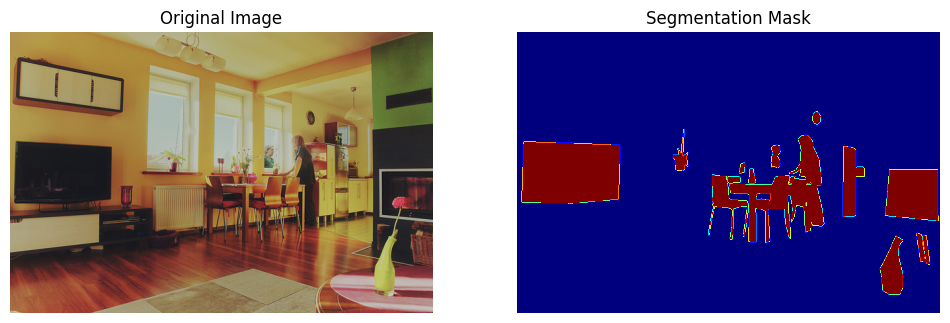

In [5]:
# Get the first sample from the dataset
sample = dataset.first()
image = plt.imread(sample.filepath)

# Get the segmentation instances from the sample
segmentations = sample["ground_truth"].detections

# Overlay each segmentation mask on the full mask
segment_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
for detection in segmentations:
    if detection.mask is not None:
        # Get the bounding box and mask [x, y, width, height]
        bbox = detection.bounding_box
        obj_mask = detection.mask

        # Calculate the pixel coordinates of the bounding box
        x, y, w, h = bbox
        x_min = int(x * image.shape[1])
        y_min = int(y * image.shape[0])
        x_max = x_min + int(w * image.shape[1])
        y_max = y_min + int(h * image.shape[0])

        # Resize the object mask to match the bounding box size, and place it in the full image mask
        obj_mask_resized = np.array(Image.fromarray(obj_mask).resize((x_max - x_min, y_max - y_min)))
        segment_mask[y_min:y_max, x_min:x_max] = np.maximum(segment_mask[y_min:y_max, x_min:x_max], obj_mask_resized)

# Plot the image and its segmentation mask
plt.figure(figsize=(12, 6))

# original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(segment_mask, cmap="jet")
plt.title("Segmentation Mask")
plt.axis("off")

plt.show()

We define a function to compute IoU as a measure of performance evaluation:

In [14]:
def calculate_all_object_iou(ground_truth, prediction):

    # unique labels for objects in the ground truth and prediction masks
    gt_labeled, gt_count = label(ground_truth)
    pred_labeled, pred_count = label(prediction)

    iou_values = {}

    for gt_obj in range(1, gt_count + 1):
        # Create a mask
        gt_mask = (gt_labeled == gt_obj)

        highest_iou = 0
        # Loop through each object in the predicted mask to compare with the current ground truth object
        for pred_obj in range(1, pred_count + 1):
            # Create a mask
            pred_mask = (pred_labeled == pred_obj)

            # Calculate the IoU
            intersection_area = np.logical_and(gt_mask, pred_mask).sum()
            union_area = np.logical_or(gt_mask, pred_mask).sum()
            if union_area != 0:
              iou = intersection_area / union_area
            else:
               0

            # highest IoU for this ground truth object
            highest_iou = max(highest_iou, iou)

        iou_values[f'Object_{gt_obj}'] = highest_iou

    return iou_values


Our Approach:

The presented algorithm here, uses a combination of techniques to create more precise segmentation. We follow these steps to get our final function:

1- Seed Initialization:

We start by initializing seeds at high-gradient locations within each grid cell, to identify potentially meaningful edges or details early in the process, and place seeds where boundaries and textures are more likely to be distinct.


2- Adaptive Region Growing:

Next, we use both color and texture thresholds, which allows the regions to grow in a way that’s responsive to local image characteristics.
Here, the algorithm evaluates each neighboring pixel by checking how close it is in color and texture to the seed region, making segmentation responsive to variations in the scene. We also use max distance, which stops regions from growing too large.

3- Boundary Refinement:

After initial segmentation, boundaries are refined by identifying pixels near edges and checking surrounding regions for better matches.
By calculating color distances for pixels along boundaries and assigning them to the best-matching region, this refinement stage helps improve visual coherence and accuracy at region boundaries, and ensures that boundaries align more accurately with actual edges in the image.

In [36]:
# Initialize seeds based on a grid and local gradient information
def initialize_seeds(image, grid_size=10):

    height, width, _ = image.shape
    seeds = []

    # the gradient magnitude
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gradient_magnitude = sobel(gray)

    # Place seeds in high-gradient areas within each grid cell
    for y in range(0, height, grid_size):
        for x in range(0, width, grid_size):
            local_patch = gradient_magnitude[y:y+grid_size, x:x+grid_size]
            max_idx = np.unravel_index(np.argmax(local_patch), local_patch.shape)
            seed_y, seed_x = max_idx[0] + y, max_idx[1] + x
            seeds.append((seed_y, seed_x))

    return seeds

# Grow regions adaptively based on color and texture similarities
def adaptive_region_growing(image, seeds, color_threshold=20, texture_threshold=5, max_distance=50):
    lab_image = rgb2lab(image)
    height, width = lab_image.shape[:2]
    labels = -np.ones((height, width), dtype=int)
    label_counter = 0

    for seed_y, seed_x in seeds:
        if labels[seed_y, seed_x] == -1:
            labels[seed_y, seed_x] = label_counter
            queue = [(seed_y, seed_x)]
            region_color = lab_image[seed_y, seed_x]

            while queue:
                y, x = queue.pop(0)

                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < height and 0 <= nx < width and labels[ny, nx] == -1:
                        color_dist = euclidean(lab_image[ny, nx], region_color)
                        if color_dist < color_threshold:
                            labels[ny, nx] = label_counter
                            queue.append((ny, nx))
            label_counter += 1

    return labels

# Refine region boundaries based on edges.
def refine_boundaries(image, labels):
    refined_labels = labels.copy()
    boundaries = find_boundaries(labels)

    for y in range(1, labels.shape[0] - 1):
        for x in range(1, labels.shape[1] - 1):
            if boundaries[y, x]:
                region_colors = [np.mean(image[labels == label], axis=0) for label in np.unique(labels[y-1:y+2, x-1:x+2])]
                best_label = np.argmin([np.linalg.norm(image[y, x] - color) for color in region_colors])
                refined_labels[y, x] = best_label

    return refined_labels

# Putting everything together
def adaptive_segmentation(image, color_threshold=20, texture_threshold=5, max_distance=50):
    seeds = initialize_seeds(image)

    initial_labels = adaptive_region_growing(image, seeds, color_threshold=color_threshold,
                                             texture_threshold=texture_threshold, max_distance=max_distance)

    refined_labels = refine_boundaries(image, initial_labels)

    return refined_labels

Applying this algorithm to the COCO image extracted:

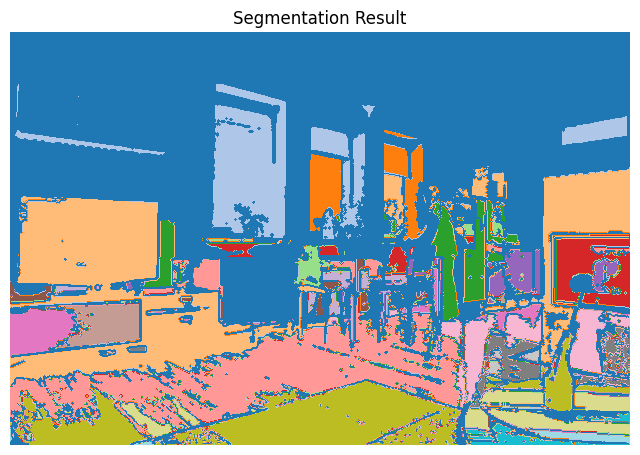

In [37]:
segmentation_result = adaptive_segmentation(image)

# Display the segmentation result
plt.figure(figsize=(8, 8))
plt.imshow(segmentation_result, cmap="tab20")
plt.title("Segmentation Result")
plt.axis("off")
plt.show()

Calculating the IoU for separate objects:

In [38]:
# ground truth mask
ground_truth_labeled, _ = label(segment_mask)

# prediction mask
prediction_mask = segmentation_result

# Calculate IoU
iou_scores = calculate_all_object_iou(ground_truth_labeled, prediction_mask)

print("IoU scores for each object:")
for obj, iou in iou_scores.items():
    print(f"{obj}: {iou}")

mean_iou = np.mean(list(iou_scores.values()))
print(f"\nMean IoU: {mean_iou}")

IoU scores for each object:
Object_1: 0.5514018691588785
Object_2: 0.003663003663003663
Object_3: 0.05039689125694631
Object_4: 0.07339338578323523
Object_5: 0.0025380710659898475
Object_6: 0.011072831810482896
Object_7: 0.009433962264150943
Object_8: 0.014634146341463415
Object_9: 0.030103664819003874
Object_10: 0.0010041667147589423
Object_11: 0.006535947712418301
Object_12: 0.01146832653579237

Mean IoU: 0.06380385559384368


We can see the output image has so many selected segments, and is a little bit noisy, so we lower the color and texture thresholds in the algorithm, to be less distinctive. The result is as below:

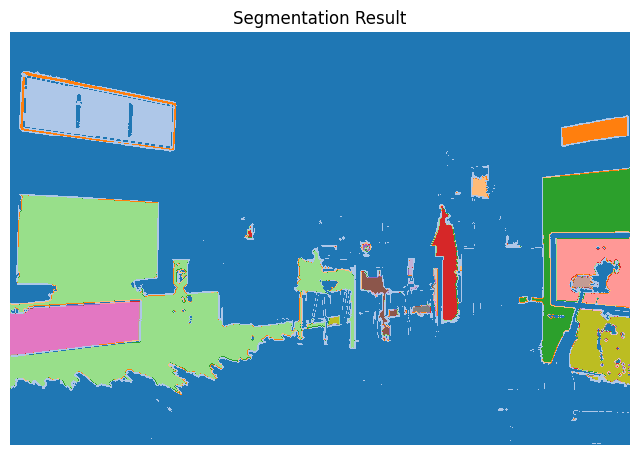

In [39]:
segmentation_result = adaptive_segmentation(image, color_threshold=50, texture_threshold=10, max_distance=100)

# Display the segmentation result
plt.figure(figsize=(8, 8))
plt.imshow(segmentation_result, cmap="tab20")
plt.title("Segmentation Result")
plt.axis("off")
plt.show()

We calculate the IoU for this one:

In [40]:
# ground truth mask
ground_truth_labeled, _ = label(segment_mask)

# prediction mask
prediction_mask = segmentation_result

# Calculate IoU
iou_scores = calculate_all_object_iou(ground_truth_labeled, prediction_mask)

print("IoU scores for each object:")
for obj, iou in iou_scores.items():
    print(f"{obj}: {iou}")

mean_iou = np.mean(list(iou_scores.values()))
print(f"\nMean IoU: {mean_iou}")

IoU scores for each object:
Object_1: 0.06735751295336788
Object_2: 0.1480836236933798
Object_3: 0.1643148904567397
Object_4: 0.33014242955929407
Object_5: 0.005076142131979695
Object_6: 0.028107158541941152
Object_7: 0.07627118644067797
Object_8: 0.0056179775280898875
Object_9: 0.7838660578386606
Object_10: 0.20408163265306123
Object_11: 0.1288297338021095
Object_12: 0.004356243949661181

Mean IoU: 0.16217538246241356


As we see, the segmentation results along with the IoU value have improved.

We perform some classical segmentation algorithms and visualize their segmentation result along with their IoU measurement. The methods used for comparison here are Watershed, SLIC, and Otsu.

1- Watershed:

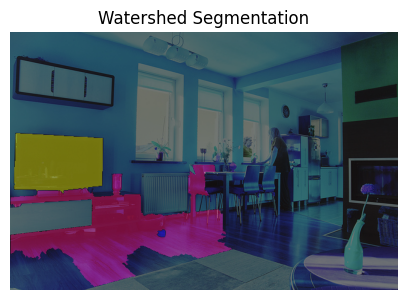

In [12]:
# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Preprocessing and noise removal
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background, foreground, unknown region, and marker labeling
sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Watershed
markers = cv2.watershed(image, markers)

# Visualization using colormap to assign distinctive colors to each segment
segmentation_visual = np.zeros_like(image)
segmentation_visual[markers == -1] = [0, 0, 0]
colormap = plt.get_cmap("hsv")
unique_labels = np.unique(markers)

for label in unique_labels:
    if label == -1 or label == 1:
        continue
    color = np.array(colormap(label / unique_labels.max())[:3]) * 255
    segmentation_visual[markers == label] = color.astype(int)

overlay = cv2.addWeighted(image, 0.6, segmentation_visual, 0.4, 0)

# Display the result
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Watershed Segmentation')
plt.axis('off')
plt.show()


Next, we calculate the IoU values for the Watershed algorithm as below:

In [17]:
# ground truth mask
ground_truth_labeled, _ = label(segment_mask)

# prediction mask
prediction_mask = np.copy(markers)
prediction_mask[prediction_mask == -1] = 0

# Calculate IoU scores
iou_scores = calculate_all_object_iou(ground_truth_labeled, prediction_mask)

print("IoU scores for each object:")
for obj, iou in iou_scores.items():
    print(f"{obj}: {iou}")

mean_iou = np.mean(list(iou_scores.values()))
print(f"\nMean IoU: {mean_iou}")

IoU scores for each object:
Object_1: 0.0008743886110883406
Object_2: 0.0024865426127824684
Object_3: 0.0405015730743985
Object_4: 0.954377218823174
Object_5: 0.0017943182956708657
Object_6: 0.01016021349655254
Object_7: 0.0004827353790383547
Object_8: 0.0008106311081964824
Object_9: 0.0259310872475886
Object_10: 0.006075293805192218
Object_11: 0.002768897268446412
Object_12: 0.009408785783898498

Mean IoU: 0.08797264045883559


2- SLIC for Superpixels

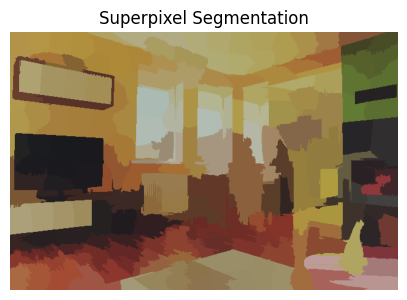

In [19]:
# Apply SLIC and Colorize the superpixel image
segments_slic = slic(image, n_segments=250, compactness=10, start_label=1)
superpixel_segmented = label2rgb(segments_slic, image, kind='avg')

# Display the result
plt.figure(figsize=(5, 5))
plt.imshow(superpixel_segmented)
plt.title('Superpixel Segmentation')
plt.axis('off')
plt.show()

the IoU values for the SLIC algorithm are as below:

In [20]:
# ground truth mask
ground_truth_labeled, _ = label(segment_mask)

# prediction mask
segments_slic = slic(image, n_segments=250, compactness=10, start_label=1)

# Calculate IoU
iou_scores = calculate_all_object_iou(ground_truth_labeled, segments_slic)

print("IoU scores for each object:")
for obj, iou in iou_scores.items():
    print(f"{obj}: {iou}")

mean_iou = np.mean(list(iou_scores.values()))
print(f"\nMean IoU: {mean_iou}")

IoU scores for each object:
Object_1: 0.0007042253521126761
Object_2: 0.0020026408450704225
Object_3: 0.03766872065727699
Object_4: 0.048048708920187796
Object_5: 0.0014451291079812206
Object_6: 0.008182951877934273
Object_7: 0.0003887910798122066
Object_8: 0.0006528755868544601
Object_9: 0.02088468309859155
Object_10: 0.0006712147887323943
Object_11: 0.0022300469483568074
Object_12: 0.007577758215962441

Mean IoU: 0.010871478873239436


3- Otsu's Method:

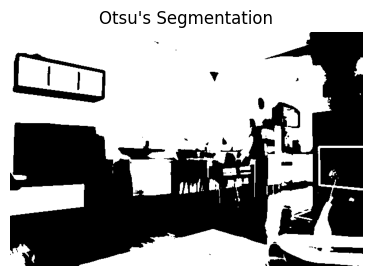

In [23]:
# Load the image in grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Gaussian Blur to reduce noise
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Otsu's thresholding
_, otsu_thresholded = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.imshow(otsu_thresholded, cmap='gray')
plt.title("Otsu's Segmentation")
plt.axis('off')
plt.show()

In [22]:
# ground truth mask
ground_truth_labeled, _ = label(segment_mask)

# predicted mask
otsu_labeled, _ = label(otsu_thresholded)

# Calculate IoU
iou_scores = calculate_all_object_iou(ground_truth_labeled, otsu_labeled)

print("IoU scores for each object:")
for obj, iou in iou_scores.items():
    print(f"{obj}: {iou}")

mean_iou = np.mean(list(iou_scores.values()))
print(f"\nMean IoU: {mean_iou}")

IoU scores for each object:
Object_1: 0.00042745837138360505
Object_2: 0.0045399309774947745
Object_3: 0.030963972736124636
Object_4: 0.0004143717950931473
Object_5: 0.0031890483413059543
Object_6: 0.02682347488558021
Object_7: 0.0009533630367531178
Object_8: 0.016853932584269662
Object_9: 0.014337478167930972
Object_10: 0
Object_11: 0
Object_12: 0.05865938550168027

Mean IoU: 0.013096868033134696


Comparison and Empirical Evidence:

Comparing the segmentation images along with the IoU values, we can see that our algorithm outperforms these traditional methods.


For your evaluation, please copy the cell below, which encapsulates our entire algorithm in a single function:

In [3]:
import numpy as np
import cv2
from skimage.color import rgb2lab
from skimage.filters import sobel
from scipy.spatial.distance import euclidean
from skimage.segmentation import find_boundaries
from skimage.measure import label
import json
import matplotlib.pyplot as plt

def adaptive_segmentation(image, ground_truth, grid_size=10, color_threshold=50, texture_threshold=10, max_distance=100):
    # Step 1: Initialize seeds based on a grid and local gradient information
    height, width, _ = image.shape
    seeds = []

    # Compute gradient magnitude for seed placement
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gradient_magnitude = sobel(gray)

    # Place seeds in high-gradient areas within each grid cell
    for y in range(0, height, grid_size):
        for x in range(0, width, grid_size):
            local_patch = gradient_magnitude[y:y+grid_size, x:x+grid_size]
            max_idx = np.unravel_index(np.argmax(local_patch), local_patch.shape)
            seed_y, seed_x = max_idx[0] + y, max_idx[1] + x
            seeds.append((seed_y, seed_x))

    # Step 2: Grow regions adaptively based on color and texture similarities
    lab_image = rgb2lab(image)
    labels = -np.ones((height, width), dtype=int)
    label_counter = 0

    for seed_y, seed_x in seeds:
        if labels[seed_y, seed_x] == -1:
            labels[seed_y, seed_x] = label_counter
            queue = [(seed_y, seed_x)]
            region_color = lab_image[seed_y, seed_x]

            while queue:
                y, x = queue.pop(0)

                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < height and 0 <= nx < width and labels[ny, nx] == -1:
                        color_dist = euclidean(lab_image[ny, nx], region_color)
                        if color_dist < color_threshold:
                            labels[ny, nx] = label_counter
                            queue.append((ny, nx))
            label_counter += 1

    # Step 3: Refine region boundaries based on edges
    refined_labels = labels.copy()
    boundaries = find_boundaries(labels)

    for y in range(1, labels.shape[0] - 1):
        for x in range(1, labels.shape[1] - 1):
            if boundaries[y, x]:
                # Calculate region colors and find the closest one
                region_colors = [np.mean(image[labels == label], axis=0) for label in np.unique(labels[y-1:y+2, x-1:x+2])]
                best_label = np.argmin([np.linalg.norm(image[y, x] - color) for color in region_colors])
                refined_labels[y, x] = best_label

    # Step 4: Calculate IoU per region within this function
    # Unique labels for objects in the ground truth and prediction masks
    gt_labeled = label(ground_truth)
    pred_labeled = label(refined_labels)

    # Count unique objects in labeled images
    gt_count = len(np.unique(gt_labeled)) - 1  # Subtract 1 to ignore the background label (0)
    pred_count = len(np.unique(pred_labeled)) - 1

    iou_values = {}

    for gt_obj in range(1, gt_count + 1):
        # Create a mask for the ground truth object
        gt_mask = (gt_labeled == gt_obj)

        highest_iou = 0
        # Loop through each object in the predicted mask to compare with the current ground truth object
        for pred_obj in range(1, pred_count + 1):
            # Create a mask for the predicted object
            pred_mask = (pred_labeled == pred_obj)

            # Calculate the IoU
            intersection_area = np.logical_and(gt_mask, pred_mask).sum()
            union_area = np.logical_or(gt_mask, pred_mask).sum()
            if union_area != 0:
                iou = intersection_area / union_area
            else:
                iou = 0

            # Highest IoU for this ground truth object
            highest_iou = max(highest_iou, iou)

        iou_values[f'Object_{gt_obj}'] = highest_iou
        print(f"IoU for Object_{gt_obj}: {highest_iou}")  # Print each IoU value

    return refined_labels, iou_values


You can call this function and plot the segmentation results as below, which was done on the cat image provided. In case you are using a json file, please first call the load_annotation function as below:

IoU for Object_1: 0.5357459754087971
IoU for Object_2: 0.13348557193273822
IoU for Object_3: 0.572429045337265


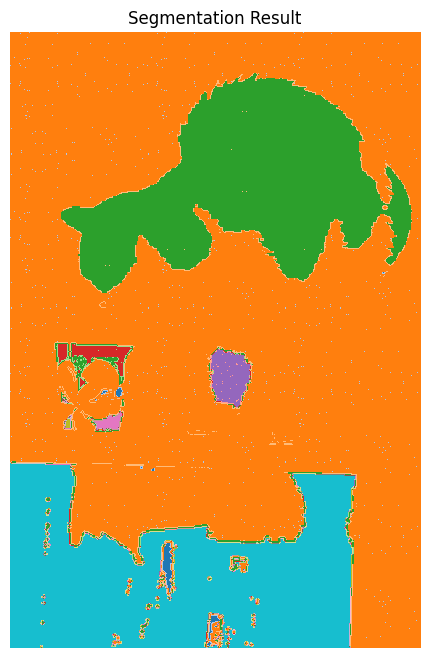

In [5]:
def load_annotation(json_path, image_shape):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Assume each object has a unique ID or label
    for i, obj in enumerate(data, 1):  
        segmentation = obj['segmentation'][0]  
        polygon = np.array(segmentation, np.int32).reshape((-1, 1, 2))  
        
        # Fill the the mask with a unique label
        cv2.fillPoly(mask, [polygon], i)  
    
    return mask

# Paths to files
original_image_path = "/scratch/ne2213/computer-vision/000000542054.jpg"
annotation_json_path = "/scratch/ne2213/computer-vision/annotations_542054.json"

# original image
original_image = cv2.imread(original_image_path)

# ground truth mask from JSON annotation
ground_truth = load_annotation(annotation_json_path, original_image.shape)

# segmentation
refined_labels, iou_values = adaptive_segmentation(original_image, ground_truth, grid_size=10, color_threshold=50)

plt.figure(figsize=(8, 8))
plt.imshow(refined_labels, cmap="tab20")  # Display segmentation result
plt.title("Segmentation Result")
plt.axis("off")
plt.show()
